

## Identifying Trends in Gun Violence Incidents in the USA from 2014 to 2018

By Miles Simpson

### Background:

Ever since the implementation of the 2nd amendment of the United States constitution, firearms have been intertwined with American history and culture. With almost double the rate of civilian per capita gun ownership than the next runner up, guns are an important and pervasive issue that is common to state and local governments across the country. In the wake of recent mass shootings, there is more motivation than ever to start to think about how to mitigate the issue of gun violence in a country filled with guns.  

While the many tragedies that have occurred over the past few decades may feel fresh in our collective memories, it is important to remember that the motivation to gain a better understanding of gun violence has been consistent for a long time, but has been stifled by a condition in CDC funding called the Dickey Amendment. The Dickey Amendment,  maintained by NRA lobbyists and their supporters in congress, all but barred the CDC from performing any studies that would produce results advocating against gun ownership until it was removed in 2018(6). This has resulted in an environment where there is a lack of quality research on gun violence issues. 

That is what makes this data set, which was collected by a non-profit organization called the Gun Violence Archive in an attempt to provide accurate information to the public, useful. The end goal of this analysis would be to identify trends that would aid policy makers and activists in being better informed as to what places, times, and people to think about when making decisions regarding gun policy. It could also indicate areas of interest for further research in the future, or even simply provide insights on keeping yourself safe.

### Research Questions:

There are a few angles to approach finding trends in data like this. There is location, data and time, and demographic data included in this set. However, because the demographic data is much less complete than the time or location data, I decided to focus mainly on those two. Within finding trends over time, it is worth investigating various different scales such as individual days of the week, days of the year, or months in order to determine if there is a difference in gun violence risk between them.  

Location data also has some intricacy to it. While the total number of incidents for a state can be a useful metric, it is worth investigating the incident rate per 100,000 people as well, as that compensates better for differences in state populations. 




#### Importing Files

In [1]:

import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy
import geopandas as gpd
import datetime
import calendar
import shapely
import plotly.graph_objects as go
import seaborn as sns
import string
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

#### Cleaning Data

In [2]:
#init clean
#Data can be found here:https://www.kaggle.com/jameslko/gun-violence-data
mdf=pd.read_csv("/work/CISC367_Final_Project/data/gun-violence-data_01-2013_03-2018.csv")

#Removing unused columns, mostly descriptions of individual incidents
mdf=mdf.drop(['n_killed','n_injured','incident_url','source_url','incident_url_fields_missing',
'congressional_district','gun_stolen','gun_type','incident_characteristics','latitude',
'location_description','longitude','n_guns_involved','notes','participant_age','participant_age_group',
'participant_name','participant_relationship','participant_status','participant_type','sources',
'state_house_district','state_senate_district','address'],axis=1)

#Introducing day of the week column
def mfindDay(date):
    day_name = datetime.datetime.strptime(date, '%Y-%m-%d').weekday()
    return (calendar.day_name[day_name])

#Categorizing day of the week to allow for sorting
from pandas.api.types import CategoricalDtype
mdf['dotw']=mdf['date'].apply(mfindDay)
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
mdf['dotw'] = mdf['dotw'].astype(cat_type)

#Introducing month column
def mfindMonth(date):
    month_num=int(date[5:7])
    months=[ 'January', 'February', 'March', 'April', 'May', 'June', 'July','August','September','October','November','December']
    month_name=months[month_num-1]
    return month_name

#Categorizing month to allow for sorting
mdf['month']=mdf['date'].apply(mfindMonth)
mcats = [ 'January', 'February', 'March', 'April', 'May', 'June', 'July','August','September','October','November','December']
cat_type = CategoricalDtype(categories=mcats, ordered=True)
mdf['month'] = mdf['month'].astype(cat_type)

#Separating day of the year and year into individual columns
def mstrpyear(string):
    string=string[0:4]
    return string
def mrmyear(string):
    return string[5:]

mdf['year']=mdf['date'].apply(mstrpyear)
mdf['m/d']=mdf['date'].apply(mrmyear)


#removing 2013 and 2018 due to incomplete data
mdf=mdf[mdf.year!='2013']
mdf=mdf[mdf.year!='2018']

#Adding state codes for plotly

def abbrev(state):
    us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',    'American Samoa': 'AS',    'Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO',    'Connecticut': 'CT',    'Delaware': 'DE',    'District of Columbia': 'DC',
    'Florida': 'FL',    'Georgia': 'GA',    'Guam': 'GU',    'Hawaii': 'HI',
    'Idaho': 'ID',    'Illinois': 'IL',    'Indiana': 'IN',    'Iowa': 'IA',
    'Kansas': 'KS',    'Kentucky': 'KY',    'Louisiana': 'LA',    'Maine': 'ME',
    'Maryland': 'MD',    'Massachusetts': 'MA',    'Michigan': 'MI',    'Minnesota': 'MN',
    'Mississippi': 'MS',    'Missouri': 'MO',    'Montana': 'MT',    'Nebraska': 'NE',
    'Nevada': 'NV',    'New Hampshire': 'NH',    'New Jersey': 'NJ',    'New Mexico': 'NM',
    'New York': 'NY',    'North Carolina': 'NC',    'North Dakota': 'ND',    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',    'Oklahoma': 'OK',    'Oregon': 'OR',    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',    'Rhode Island': 'RI',    'South Carolina': 'SC',    'South Dakota': 'SD',
    'Tennessee': 'TN',    'Texas': 'TX',    'Utah': 'UT',    'Vermont': 'VT',
    'Virgin Islands': 'VI',    'Virginia': 'VA',    'Washington': 'WA',    'West Virginia': 'WV',
    'Wisconsin': 'WI',    'Wyoming': 'WY'
    
}
    return us_state_abbrev[state]

mdf['state_code']=mdf['state'].apply(abbrev)

def rev_abbrev(abbreviated):
    us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',    'American Samoa': 'AS',    'Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO',    'Connecticut': 'CT',    'Delaware': 'DE',    'District of Columbia': 'DC',
    'Florida': 'FL',    'Georgia': 'GA',    'Guam': 'GU',    'Hawaii': 'HI',
    'Idaho': 'ID',    'Illinois': 'IL',    'Indiana': 'IN',    'Iowa': 'IA',
    'Kansas': 'KS',    'Kentucky': 'KY',    'Louisiana': 'LA',    'Maine': 'ME',
    'Maryland': 'MD',    'Massachusetts': 'MA',    'Michigan': 'MI',    'Minnesota': 'MN',
    'Mississippi': 'MS',    'Missouri': 'MO',    'Montana': 'MT',    'Nebraska': 'NE',
    'Nevada': 'NV',    'New Hampshire': 'NH',    'New Jersey': 'NJ',    'New Mexico': 'NM',
    'New York': 'NY',    'North Carolina': 'NC',    'North Dakota': 'ND',    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',    'Oklahoma': 'OK',    'Oregon': 'OR',    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',    'Rhode Island': 'RI',    'South Carolina': 'SC',    'South Dakota': 'SD',
    'Tennessee': 'TN',    'Texas': 'TX',    'Utah': 'UT',    'Vermont': 'VT',
    'Virgin Islands': 'VI',    'Virginia': 'VA',    'Washington': 'WA',    'West Virginia': 'WV',
    'Wisconsin': 'WI',    'Wyoming': 'WY'
    
}
    abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))
    return abbrev_us_state[abbreviated]

census=pd.read_csv("/work/CISC367_Final_Project/data/nst-est2019-01.csv",thousands=',')

#Using average estimated population from 2014 through 2017
census=census.iloc[:,[0,7,8,9,10]]
cen=census.iloc[:,1:4]
census['mean']=cen.mean(axis=1)
census=census.iloc[:,[0,5]]
census['Geographic Area']=census['Geographic Area'].apply(abbrev)

#### Displaying Data Sets

In [3]:
mdf.head()

,incident_id,date,state,city_or_county,participant_gender,dotw,month,year,m/d,state_code
278,95289,2014-01-01,Michigan,Muskegon,0::Female,Wednesday,January,2014,01-01,MI
279,92401,2014-01-01,New Jersey,Newark,NaN,Wednesday,January,2014,01-01,NJ
280,92383,2014-01-01,New York,Queens,0::Male||1::Male,Wednesday,January,2014,01-01,NY
281,92142,2014-01-01,New York,Brooklyn,0::Male||1::Male,Wednesday,January,2014,01-01,NY
282,95261,2014-01-01,Missouri,Springfield,0::Female,Wednesday,January,2014,01-01,MO


In [4]:
census.head()

,Geographic Area,mean
0,AL,4.852557e+06
1,AK,7.384123e+05
2,AZ,6.833720e+06
3,AR,2.978453e+06
4,CA,3.889404e+07


#### Days of the Week  
Are there any significant trends between the weekdays and the weekend?

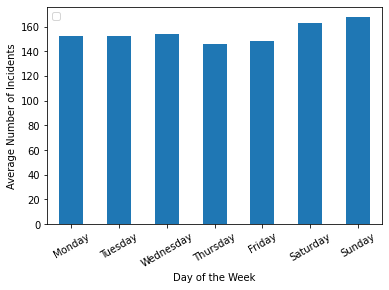

In [5]:

df=mdf
agg=df.groupby('date')['incident_id'].count().reset_index()
agg['dotw']=agg['date'].apply(mfindDay)

cat_type = CategoricalDtype(categories=cats, ordered=True)
agg['dotw'] = agg['dotw'].astype(cat_type)
agg.groupby('dotw').mean().plot.bar(rot=30)
plt.xlabel('Day of the Week')
plt.ylabel('Average Number of Incidents')
plt.legend('')

There is a slight jump in incidents on the weekend, most likely due to people being less restricted by the standard 9 to 5 workday. It is worth investigating to see if this difference is significant or not.

#### Weekend vs Weekday t test

In [6]:

weekday_means=agg.set_index('dotw').loc[['Monday','Tuesday','Wednesday','Thursday','Friday']]['incident_id'].to_list()
weekend_means=agg.set_index('dotw').loc[['Saturday','Sunday']]['incident_id'].to_list()

st.ttest_ind(weekday_means,weekend_means)

Ttest_indResult(statistic=-10.00288732852679, pvalue=7.919599978256679e-23)

This P value is less than 0.05, which means that the difference between weekends and weekdays, while relatively small in magnitude, is statistically significant. This would indicate that it is significantly more dangerous to be out on a weekend than a weekday. 

#### Day of the Year

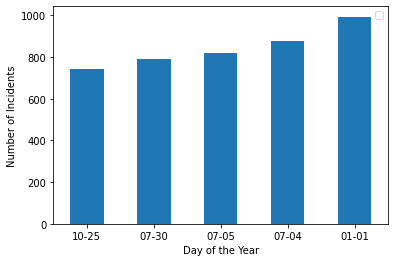

In [7]:

df.groupby('m/d')['incident_id'].count().reset_index().sort_values('incident_id').tail().plot.bar(x='m/d',rot=0)
plt.xlabel('Day of the Year')
plt.ylabel('Number of Incidents')
plt.legend('')

The most active days of the year for gun incidents are New Year's day and July 4th. This is most likely due to the large numbers of people who go out in public at once, increasing the number of potential conflicts and victims. The spike from New Year's day is large enough that it offsets some of the next trend to investigate, that of differences between months.

#### Month of the Year

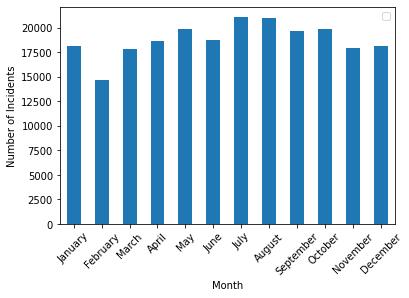

In [8]:

df=mdf
df.groupby('month')['incident_id'].count().reset_index().plot.bar(x='month',rot=45)
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.legend('')

This plot shows total incidences over months of the year, and connects to the previous plot with a spike on New Year's day. That spike somewhat counteracts the otherwise present trend that warmer months result in higher incident rates. Apart from the straightforward reason that people can't commit crimes if they stay home out of the cold, there is also a somewhat subtler influence at work when looking at rates of violent crime. The fact that heat increases aggression in humans. Multiple studies (3) have been conducted that showed that, while adjusting for everything else, warmer environments induce a slight but noticeable rise in aggression across entire societies. This ties the issue of gun violence to another major issue, climate change. As the world continues to warm, that minor influence will continue to act to increase violent crimes alongside it, as well as create other crises that result in disenfranchised people who are at more risk of resorting to criminal acts.

#### Year Comparison

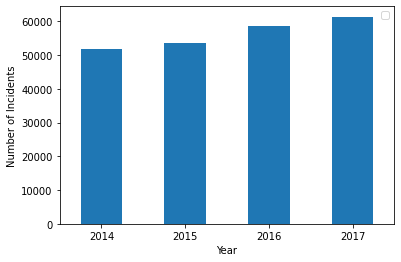

In [9]:

df.groupby('year').count().plot.bar(y='incident_id',rot=0)
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.legend('')

This plot of total gun violence incidents over multiple years shows a slow but steady increase, but is that increase statistically significant in the data?

#### Significance of Trend Over Years

In [10]:

x=[[2014],[2015],[2016],[2017]]
y=df.groupby('year').count().reset_index()['incident_id'].to_list()

model=LinearRegression(fit_intercept=True);
model.fit(x, y)
xfit=np.linspace(2014,2017,4)
yfit=model.predict(xfit[:, np.newaxis])

from sklearn.feature_selection import f_regression

freg=f_regression(x,y)

p=freg[1]

print(p.round(3))

[0.017]


Because the P value is less than 0.05, it is possible to reject the null hypothesis, that gun violence is not significantly increasing over time. In addition to this analysis, the Gun Violence Archive is still tracking total incidents, and they have continued to rise since 2018 (4). There has been an additional spike on top of the steady incline in recent times due to people feeling insecure from the COVID-19 pandemic as well (5). 

#### Total Incidents by State

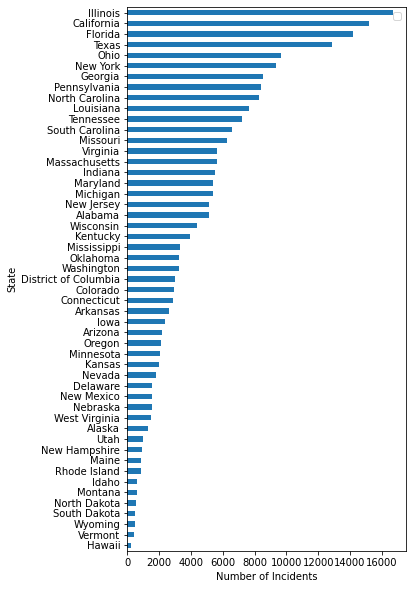

In [11]:
#state top #
df=mdf
df.groupby('state')['incident_id'].count().reset_index().sort_values('incident_id').plot.barh(x='state',y='incident_id',figsize=(5,10))
plt.xlabel('Number of Incidents')
plt.ylabel('State')
plt.legend('')

In [12]:
#state # map
df=df.groupby('state_code')['incident_id'].count().reset_index()
fig = go.Figure(data=go.Choropleth(
    locations=df['state_code'], # Spatial coordinates
    z = df['incident_id'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "# Incidents",
))

fig.update_layout(
    title_text = 'Total Gun Violence Incidents 2014-2017 by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()
#Doesn't work with html versions of .ipynb, image below is a screen capture

![Total Gun Violence Map](data/image-20210526-055051.png)

The map and ranking above show some interesting trends of the total gun violence incidents between states. Some states are expected to have high numbers, such as very populous states such as California or New York, while others have medium populations but high gun ownership, such as Texas and Louisiana. One outlier that was somewhat unexpected was Illinois, which I suspect is due to Chicago, but further exploration is required.

#### Number of Incidents per 100,000 People by State

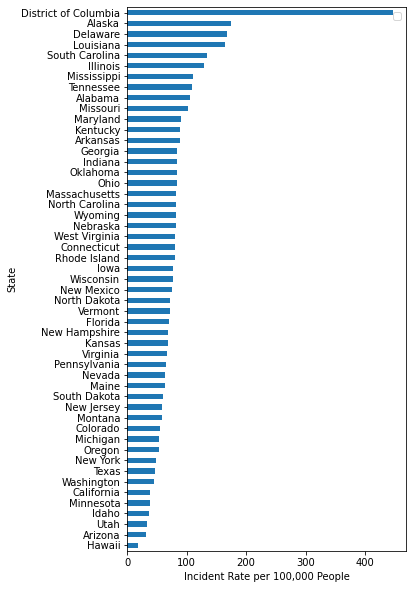

In [13]:
#state top rate
df=mdf
df=df.groupby('state_code')['incident_id'].count().reset_index()
#Joining main dataframe and census data to calculate incident rate per 100,000 people
df=df.set_index('state_code').join(census.set_index('Geographic Area')).reset_index()


def incident_rate(row):
    return 100000*row['incident_id']/row['mean']

df['incident_rate']=df.apply(incident_rate,axis=1)

#Adding back in full state names
df['state']=df['state_code'].apply(rev_abbrev)

df.sort_values('incident_rate').plot.barh(x='state',y='incident_rate',figsize=(5,10))

plt.xlabel('Incident Rate per 100,000 People')
plt.ylabel('State')
plt.legend('')

With the incident numbers now adjusted for population, Alaska, Washington DC, and Delaware shoot towards the top. It's likely that these spikes are due to the proportion of the state population that lives in an urban area, which would increase the rates of gun violence. Washington DC especially, as the entire district is essentially just the inner city and capitol hill areas, with wealthier areas that would result in lower gun violence rates all lying on the outside of its borders. Alaska has a very low polulation and a very high gun ownership rate, and Delaware has a low overall population, and has a high amount of people living in the urban area of Wilmington.

In [14]:

#Exclude DC due to not being plotted and throwing off y axis
df=df[df.state_code!='DC']

fig = go.Figure(data=go.Choropleth(
    locations=df['state_code'], # Spatial coordinates
    z = df['incident_rate'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "# Incidents per 100,000 People",
))

fig.update_layout(
    title_text = 'Gun Violence Incident Rate per 100,000 People from 2014-2017 by State',
    geo_scope='usa', # limit map scope to USA
)

fig.show()
#Doesn't work with html versions of .ipynb, image below is a screen capture

![Gun Violence Rate State Map](data/image-20210526-055528.png)

Here is a visualization of the gun violence incident rates across the US as a map. One pattern present here is a clustering of high incident rates in the southeast, which fits expectations as that region has a stronger culture of gun ownership than further north or the west coast.

#### Total Number of Incidents by City or County

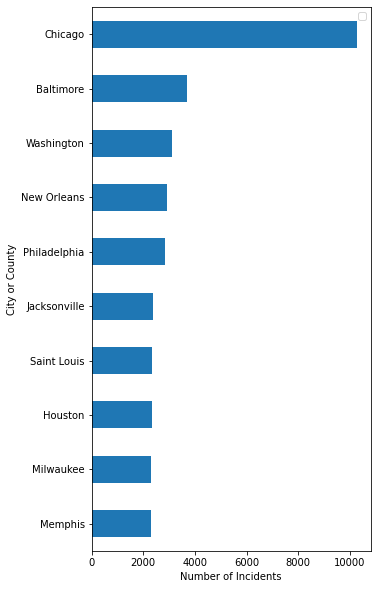

In [15]:

df=mdf
df.groupby('city_or_county')['incident_id'].count().reset_index().sort_values('incident_id').tail(10).plot.barh(x='city_or_county',y='incident_id',figsize=(5,10))
plt.xlabel('Number of Incidents')
plt.ylabel('City or County')
plt.legend('')

The ranking of cities confirms my suspicions from earlier, that Illinois has so many incidents mainly due to Chicago. In addition, Louisiana's high spot is supported by the presence of New Orleans high on this chart as well.  


#### Male vs Female Participants in Gun Violence

([<matplotlib.patches.Wedge at 0x7fde5bfef310>,
 [Text(-1.019817466479084, 0.41227701253427024, 'Male'),
  Text(1.0198174857791624, -0.4122769647931693, 'Female')])

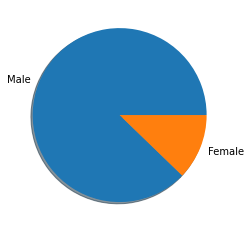

In [16]:

df=df.dropna(subset=['participant_gender'])

def count_male(string):
    t=string.count('Male')
    return t

def count_female(string):
    t=string.count('Female')
    return t


df['male_participants']=df['participant_gender'].apply(count_male)
df['female_participants']=df['participant_gender'].apply(count_female)

num_female=df['female_participants'].sum()
num_male=df['male_participants'].sum()
mpercent=num_male/(num_female+num_male)*100
fpercent=num_female/(num_female+num_male)*100
plt.pie([mpercent,fpercent],labels=['Male','Female'],shadow=True)

While I was expecting some level of gender imbalance in gun violence incidents, I didn't expect it to be this drastic. Roughly 88 percent of participants in incidents are male. This imbalance is most likely stemming from a variety of factors, such as cultural influences of what masculinity looks like and biological differences in risk taking behavior.

### Ethical Concerns:  
There are a few key ethical concerns when it comes to analyzing data sets such as this one. One major risk is the creation of harmful stereotypes of places or people. For example, in this analysis it was shown that a significant proportion of Illinois' gun violence incidents happen in Chicago. This could foster resentment in people who live outside of the urban areas, furthering an already existing rural urban divide in the United States. Additionally, the highly imbalanced gender ratio of gun violence could result in women feeling less safe altogether.  

Another concern is that gun control is a very politically charged and tense issue, and a report like one the CDC might produce that takes a side could reduce trust in the institution with people who are at the most risk, especially now, when people need to get vaccinated for COVID-19.  

### Conclusion:

The analysis of this dataset has produced a number of useful trends, many of which merit further study. The overall rise in national gun violence incidents over the years presents an issue that could take a lot of analysis to determine the causes of. There is also plenty of room for study on individual states and cities, in order to find ways to make the US a safer place. More detailed demographics studies on smaller scales could allow local and state governments to create programs or laws that address some of the root causes of gun violence, such as mental health and economic inequality.

Sources:  
1: https://www.gq.com/story/inside-federal-bureau-of-way-too-many-guns  
2: https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html  
3: https://www.psychologicalscience.org/observer/global-warming-and-violent-behavior  
4: https://www.gunviolencearchive.org/  
5: https://www.nbcnews.com/politics/meet-the-press/blog/meet-press-blog-latest-news-analysis-data-driving-political-discussion-n988541/ncrd1223551#blogHeader  
6: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5993413/





In [17]:
!jupyter nbconvert --to html Final-GunViolenceStats.ipynb

[NbConvertApp] Converting notebook Final-GunViolenceStats.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('execution_count', 'outputs' were unexpected)

Failed validating 'additionalProperties' in markdown_cell:

On instance['cells'][5]:
{'cell_type': 'markdown',
 'execution_count': 187,
 'metadata': {'cell_id': '00006-563160d2-df01-4856-95ba-c5148fed735e',
              'deepnote_cell_type': 'markdown',
              'deepnote_to_be_reexecuted': False,
              'execution_millis': 0,
              'execution_start': 1622028151542,
              'source_hash': '6aa78a58',
              'tags': []},
 'outputs': ['...0 outputs...'],
 'source': '#### Displaying Data Sets'}
[NbConvertApp] Writing 840460 bytes to Final-GunViolenceStats.html


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8fad058d-ad55-449d-a4e6-d77086f48415' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>